In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

 Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()
['measurement', 'station']

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

 Exploratory Climate Analysis

In [10]:
#exploring dataset

from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2017-08-23',)


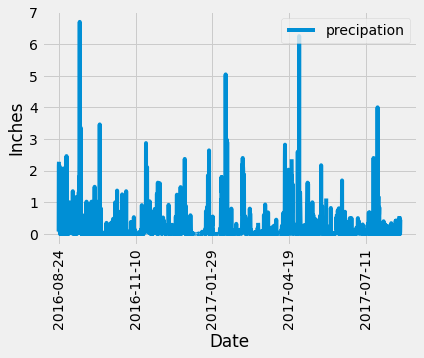

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("select * from Measurement limit 12").fetchall()
session.query(func.count(Measurement.date)).all()
# Calculate the date 1 year ago from the last data point in the database
date_one_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(date_one_year)

one_year_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date>one_year_back).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(scores)
df = df.rename(columns={"prcp":"precipation"})
# Sort the dataframe by date
df.sort_values(by=['date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'precipation')
plt.legend(loc = "upper right")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90);

In [12]:
#Use Pandas to print the summary statistics for the precipitation data.
df.describe()

,precipation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_records = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_stations[0][0]).all()

temp_records

[(54.0, 85.0, 71.66378066378067)]

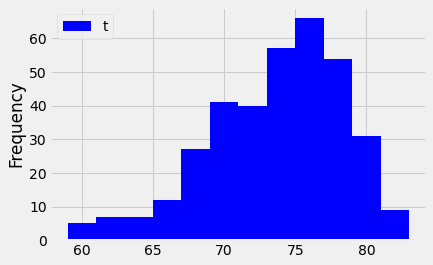

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_hightemp = session.query(Measurement.date).order_by(Measurement.date.desc()).\
    filter(Measurement.station == active_stations[0][0]).all()

date = list(np.ravel(station_hightemp))[0]
recent_date = dt.datetime.strptime(date, "%Y-%m-%d")
station_year_back = recent_date - dt.timedelta(days=365)

station_temp = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date>station_year_back).all()

station_temp_df = pd.DataFrame(station_temp)

histogram = station_temp_df["tobs"].hist(bins=12,color='blue')
histogram.set_ylabel("Frequency")
histogram.legend('tobs', loc = "upper left");